In [5]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install torch transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [9]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load and preprocess the dataset
data = []
with open("/content/drive/Shared drives/DATA298B/Readmission/final_enhanced_patient_summaries.json") as f:
    for line in f:
        data.append(json.loads(line))

# Prepare the data into lists for inputs and labels
texts = [item['enhanced_summary'] for item in data]
labels = [1 if item['readmission_status'] == "yes" else 0 for item in data]

# Split the data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("medicalai/ClinicalBERT", num_labels=2)

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Create Dataset objects
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
val_dataset = Dataset.from_dict({"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"], "labels": val_labels})

# Define compute_metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set up training arguments without W&B
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none",  # Disable W&B
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("/content/drive/Shared drives/DATA298B/Readmission/fine_tuned_clinicalbert")

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.161808,0.951020,0.950413,0.912698,0.991379
2,No log,0.108980,0.959184,0.956897,0.956897,0.956897
3,No log,0.117603,0.963265,0.961702,0.949580,0.974138


Evaluation results: {'eval_loss': 0.1176026314496994, 'eval_accuracy': 0.963265306122449, 'eval_f1': 0.9617021276595744, 'eval_precision': 0.9495798319327731, 'eval_recall': 0.9741379310344828, 'eval_runtime': 2.6004, 'eval_samples_per_second': 94.215, 'eval_steps_per_second': 11.921, 'epoch': 3.0}


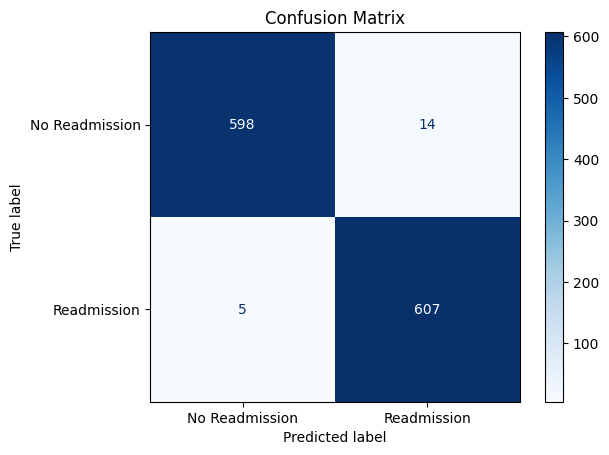

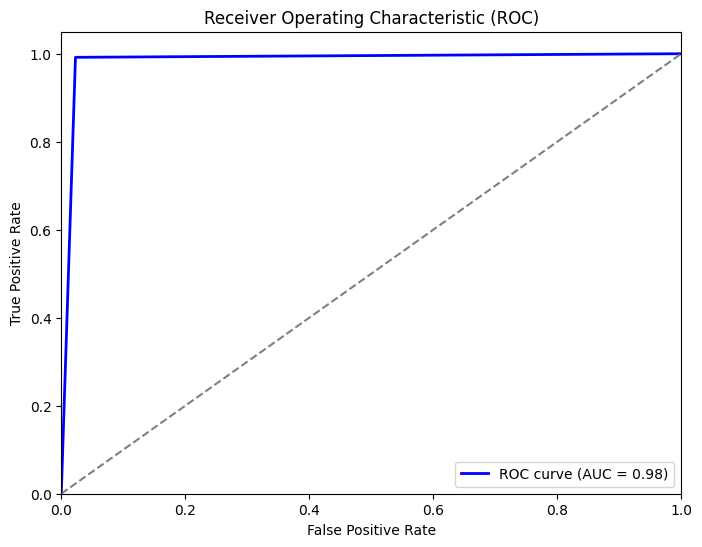

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/Shared drives/DATA298B/Readmission/fine_tuned_clinicalbert")
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

# Create the validation encodings
val_texts = [item['enhanced_summary'] for item in data]  # Replace 'data' with the actual dataset
val_labels = [1 if item['readmission_status'] == "yes" else 0 for item in data]

val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert the validation data into a Dataset
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

# Define the collate function to properly handle the data during batching
def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch])
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# Prepare DataLoader for evaluation
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict on the validation set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Append predictions and true labels
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmission"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate AUC-ROC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/Shared drives/DATA298B/Readmission/fine_tuned_clinicalbert")
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

# Set the model to evaluation mode
model.eval()

# Define a function to make predictions on new summaries
def predict_summary(summary):
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return "Readmission" if prediction == 1 else "No Readmission"

# Example: Predict on new summaries
new_summaries = [
   "The patient is a 65-year-old female with a history of congestive heart failure and chronic obstructive pulmonary disease (COPD). She was admitted for acute exacerbation of COPD, presenting with severe shortness of breath and low oxygen saturation. During her hospital stay, her condition required frequent adjustments to her oxygen therapy and multiple high-dose steroid treatments. The discharge plan included oxygen therapy at home and follow-up in one week. However, she lives alone and expressed concerns about managing her medications and oxygen setup. Her last lab results showed borderline low sodium and elevated blood urea nitrogen, with fluctuating blood pressure readings. She also had a recent hospitalization three weeks ago for a similar issue.",
                "The patient is a 45-year-old male with hypertension and Type 2 diabetes, who was admitted for routine monitoring after an elective orthopedic surgery. His hospital course was stable, with no complications, and he showed consistent improvement in mobility and pain control. Vital signs and lab results were within normal ranges at discharge. He was discharged with a home exercise plan and clear instructions on managing post-operative care, including regular check-ups with his primary physician. He has a strong support system at home, with family members who can assist with his care as needed. No significant health issues were noted at discharge.",
                  "The patient is a 50-year-old male with schizophrenia and Type 2 diabetes, admitted for hyperglycemia and dehydration. He was stabilized with insulin and rehydration during his stay. However, he has a history of non-adherence to medication, which complicates his diabetes management. He is being discharged with insulin therapy and has been referred for mental health follow-up, but he has a limited support system. His lab results at discharge were within normal ranges, but his history of inconsistent medication adherence and frequent admissions suggests a high risk of readmission.",
                  "The patient is a 55-year-old female with no significant prior medical history, admitted for knee replacement surgery. Her postoperative recovery was smooth, with no complications, and her vital signs remained stable throughout her stay. Physical therapy sessions showed good progress, and she was discharged with clear instructions for exercises and a follow-up with her orthopedic surgeon in two weeks. She has family support at home, and all necessary pain medications and supplies were arranged prior to discharge. Her final lab results were within normal limits, indicating a low risk of complications."
]

# Make predictions
for summary in new_summaries:
    result = predict_summary(summary)
    print(f"Summary: {summary}\nPrediction: {result}\n")


Summary: The patient is a 65-year-old female with a history of congestive heart failure and chronic obstructive pulmonary disease (COPD). She was admitted for acute exacerbation of COPD, presenting with severe shortness of breath and low oxygen saturation. During her hospital stay, her condition required frequent adjustments to her oxygen therapy and multiple high-dose steroid treatments. The discharge plan included oxygen therapy at home and follow-up in one week. However, she lives alone and expressed concerns about managing her medications and oxygen setup. Her last lab results showed borderline low sodium and elevated blood urea nitrogen, with fluctuating blood pressure readings. She also had a recent hospitalization three weeks ago for a similar issue.
Prediction: Readmission

Summary: The patient is a 45-year-old male with hypertension and Type 2 diabetes, who was admitted for routine monitoring after an elective orthopedic surgery. His hospital course was stable, with no complic